# Salary prediction via Deep NLP methods
A recent Kaggle competition (merely 5 years) propose you to find out who is the most well-paid professional

We are gonna solve regression task.

Competition is available here: https://www.kaggle.com/c/job-salary-prediction

![Hobby](https://imgs.xkcd.com/comics/extrapolating.png)

In this notebook you will learn
 - Data preprocessing for NLP or the most annoying part of data scientist's job
 - Convolutional Neural Networks for texts
 - Constructing you NN with scripting

# Data

Dataset is consists of job data. Most of it is an unstructured text. You should predict annual salary

Download here: https://yadi.sk/d/vVEOWPFY3NruT7 or from competition

You need to download Train_rev1.zip and unpack it
## Main fields

Title - A freetext field supplied to us by the job advertiser as the Title of the job ad.  Normally this is a summary of the job title or role.

FullDescription - The full text of the job ad as provided by the job advertiser.  Where you see ***s, we have stripped values from the description in order to ensure that no salary information appears within the descriptions.  There may be some collateral damage here where we have also removed other numerics.

LocationRaw - The freetext location as provided by the job advertiser.

LocationNormalized - Adzuna's normalised location from within our own location tree, interpreted by us based on the raw location.  Our normaliser is not perfect!

ContractType - full_time or part_time, interpreted by Adzuna from description or a specific additional field we received from the advertiser.

ContractTime - permanent or contract, interpreted by Adzuna from description or a specific additional field we received from the advertiser.

Company - the name of the employer as supplied to us by the job advertiser.

Category - which of 30 standard job categories this ad fits into, inferred in a very messy way based on the source the ad came from.  We know there is a lot of noise and error in this field.

## Desiered field
SalaryRaw - the freetext salary field we received in the job advert from the advertiser.


In [1]:
import pandas as pd
import numpy as np
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
X = pd.DataFrame.from_csv('Train_rev1.csv', index_col=None)
X.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


In [3]:
X.ContractType = X.ContractType.astype(str)
X.ContractTime = X.ContractTime.astype(str)
X.Company = X.Company.astype(str)

In [4]:
Y = X['SalaryNormalized'].copy()

In [5]:
del X['Id'],  X['SalaryRaw'], X['SourceName'], X['SalaryNormalized']

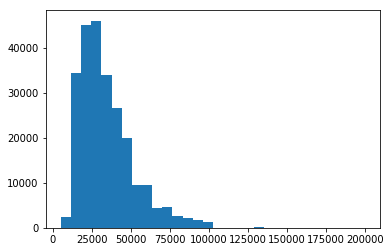

In [6]:
_ = plt.hist(Y, bins=30)

# Preprocessing
At this very stage we will distill valuable data out of the dataset

First of all - let's remove rare tokens and finalaize our dictionary

We count all tokens ever occurred in any of `text_columns`

In [7]:
text_columns = list(X.columns)
print(text_columns)
categorial_colums = ['ContractType', 'ContractTime', 'Company', 'Category']

['Title', 'FullDescription', 'LocationRaw', 'LocationNormalized', 'ContractType', 'ContractTime', 'Company', 'Category']


Your code is below. 

Remember to apply .lower() to all strings before tokenization

Consider using tqdm_notebook for not dying  during the iteration process

In [8]:
from nltk.tokenize import RegexpTokenizer
from collections import Counter,defaultdict
tokenizer = RegexpTokenizer(r"\w+|\d+")

#Dictionary of tokens
token_counts = Counter()

def tokenize(value):
    """ Returns a list of string tokens
    Arguments:
    value -- string to tokenize
    """
    return tokenizer.tokenize(value.lower())

for i in text_columns:
    for s in (X[i].values):
        try:
            token_counts.update(tokenize(s))
        except:
            print(i)

# <YOUR CODE HERE>

Title


In [9]:
token_counts.most_common(1)

[('and', 2663215)]

In [10]:
token_counts.most_common(1)[0]

('and', 2663215)

In [11]:
token_counts.most_common(1)[0][1]

2663215

In [12]:
len(token_counts)

205062

In [13]:
assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Correct!


Now is the time to actually build token dict. We will use only words that occur more than `min_count` times in dataset

Fill two dict mappings id->token and token->id

**Minimum id is 2**, because 0 is reserved for padding and 1 is UNK

In [14]:
min_count = 10

tokens = [w for w, c in token_counts.items() if c > min_count] 

In [15]:
assert type(tokens)==list
assert len(tokens) in range(32000,34000)
assert 'me' in tokens
print("Correct!")

Correct!


In [16]:
dict_size = len(tokens)+2
id_to_word = dict()
word_to_id = dict()

token_to_id = {t:i+2 for i,t in enumerate(tokens)}

id_to_token = {i+2:t for i,t in enumerate(tokens)}

In [17]:
assert token_to_id['me'] != token_to_id['woods']
assert token_to_id[id_to_token[42]]==42
assert len(token_to_id)==len(tokens)
assert 0 not in id_to_token

In [18]:
def vectorize(strings, token_to_id, UNK):
    '''This function gets a string array and transforms it to padded token matrix
    Remember to:
     - Transform a string to list of tokens
     - Transform each token to it ids (if not in the dict, replace with UNK)
     - Pad each line to max_len'''
    max_len = 0
    token_matrix = []
    
    for i in range(len(strings)):
        t=tokenize(strings[i])
        max_len = max(max_len, len(t))
        token_matrix.append([])
        for k in t:
            if k not in token_to_id:
                token_matrix[i].append(UNK)
            else:
                token_matrix[i].append(token_to_id[k])
    for i in range(len(token_matrix)):
        while(len(token_matrix[i])<max_len):
            token_matrix[i].append(0)
            
    
#     <YOUR CODE HERE>
    return np.array(token_matrix)

In [19]:
test = vectorize(["Hello, adshkjasdhkas", "data"], token_to_id, 1)
assert test.shape==(2,2)
assert (test[:,1]==(1,0)).all()
print("Correct!")

Correct!


In [20]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 1000)

**If you successfully completed all tasks by this moment, you get (2 pts)**

# True deep learning

Now we will define our convolutional neural network.

We will think about categorical fields as a sequential - but we won't apply CNN to them

In [21]:
import tensorflow as tf
tf.reset_default_graph()

Initialaize some placeholders for data

What size it should  be?

In [22]:
placeholders = dict()
for col in text_columns:
    placeholders[col] = tf.placeholder(dtype=tf.int32,
                                        shape=[None, None],
                                        name="word_ids_%s"%col)
    
true_y = tf.placeholder(dtype=tf.float32, shape = [None], name="true_y")

Embeddings are vector representations for tokens. Basically it is just a table where each token (represented by it's id) has a vector representing its sense.

It will be learned simultaneously with other layers

In [23]:
embeddings_size = 128
word_embeddings_matrix = tf.get_variable(name="word_embeddings_matrix",
                                         dtype=tf.float32,
                                         initializer=tf.random_normal(
                                             shape=[dict_size, embeddings_size], #<your_code_here>
                                             stddev=0.05))

## Deep nets
Below we are gonna define some network architectures corresponding to each input (a column from a source data)

`tf.layers.conv1d()` has three parameters. 
 - inputs is a tensor with [batch_size, time, embedding_dimension]
 - filters is an int number which means number of channels on the output
 - kernel_size is an int number which means a size of input data which will be convoluted

**Please, specify a padding='same'. This will prevent errors in case of low **
`tf.layers.conv1d()` returns a tensor with dimension  [batch_size, time, filters]

`tf.layers.max_pooling1d()` is prerry much the same. The only thing you need to specify - pool size and strides.

For global pooling you can use `tf.reduce_max()`

In [24]:
filter_sizes = [3, 4, 5]
num_filters = 128
drop = 0.5
sequence_length = max(len(w) for w in tokens)

In [25]:
# 3464.55935

def dream_neural_net(word_ids, name):
    """Function takes an int32 matrix [batch_size, time] and returnes infered [batch_size, dense_vector] 
    matrix with a conv and pooling layers, finished by a global pooling"""
    with tf.variable_scope(name_or_scope="conv_" + name):
        
        output = tf.nn.embedding_lookup(params=word_embeddings_matrix,
                                             ids=word_ids) #returns [batch_size, time, embedding_dimension]
#         <YOUR CODE HERE>
    
    inputSize = int(output.get_shape()[-1])

    output0 = tf.layers.conv1d(inputs=output, 
                              filters=sequence_length - filter_sizes[0] + 1, 
                              kernel_size=filter_sizes[0],  
                              padding='same',
                              activation=tf.nn.elu)
    
    output0 = tf.reduce_max(output0,axis=1)
    
    output1 = tf.layers.conv1d(inputs=output, 
                              filters=sequence_length - filter_sizes[1] + 1, 
                              kernel_size=filter_sizes[1],  
                              padding='same',
                              activation=tf.nn.elu)
    
    output1 = tf.reduce_max(output1,axis=1)
    
    output2 = tf.layers.conv1d(inputs=output, 
                              filters=sequence_length - filter_sizes[2] + 1, 
                              kernel_size=filter_sizes[2],  
                              padding='same',
                              activation=tf.nn.elu)
    
    output2 = tf.reduce_max(output2,axis=1)
    
    merged_tensor = tf.concat([output0, output1, output2],axis=1)
    
    output = merged_tensor
    
    dropout = tf.layers.dropout(merged_tensor, rate=drop)
    
    output = dropout

#     output = tf.reduce_mean(output, axis=0)
#     output = tf.layers.dense(output, units=128, activation=tf.nn.softmax)
    
    print("num ", output.shape)
    return output

In [26]:
def dream_neural_net_categorial(word_ids, name):
    """Function takes an int32 matrix [batch_size, time] and returnes infered [batch_size, latent_dim] 
    matrix without a conv and pooling layers, only dense layers"""
    output = tf.nn.embedding_lookup(params=word_embeddings_matrix,
                                         ids=word_ids) #returns [batch_size, time, embedding_dimension]

#     output = tf.layers.max_pooling1d(inputs=output, 
#                                      pool_size=sequence_length - filter_sizes[0] + 1, 
#                                      strides=1, 
#                                      padding='same')
    output = tf.reduce_sum(output,axis=1)
    print("cat ", output.shape)
    return output

Now it is time to combine all architectures. In a dict below you can match input type and an architecture

In [27]:
nets_types = {'FullDescription': dream_neural_net, 
 'LocationRaw': dream_neural_net, 
 'Title': dream_neural_net, 
              
 'LocationNormalized': dream_neural_net_categorial,             
 'ContractType': dream_neural_net_categorial, 
 'ContractTime': dream_neural_net_categorial, 
 'Company': dream_neural_net_categorial, 
 'Category':dream_neural_net_categorial
}

In [28]:
#here we apply specified architecture for each input 
outputs_to_concat = [nets_types[name](word_ids, name) for name, word_ids in placeholders.items()] 
dense_repr = tf.concat(outputs_to_concat, axis=1)

num  (?, 225)
num  (?, 225)
num  (?, 225)
cat  (?, 128)
cat  (?, 128)
cat  (?, 128)
cat  (?, 128)
cat  (?, 128)


In [29]:
dense_repr.get_shape()

TensorShape([Dimension(None), Dimension(1315)])

In [30]:
assert len(dense_repr.get_shape().as_list())==2

In [31]:
def reduce_to_number(dense_inputs):
    
    output = tf.layers.dense(dense_inputs, 50) 
    output = tf.contrib.layers.fully_connected(inputs=output,
                                               num_outputs=1,
                                               activation_fn=None,
                                               weights_initializer=tf.contrib.layers.xavier_initializer(),
                                               biases_initializer=tf.zeros_initializer(),
                                               scope="dense_2")
    return output

In [32]:
net_output = reduce_to_number(dense_repr)
predicted_y = tf.reshape(net_output, (-1, ))

In [33]:
net_output.get_shape().as_list()

[None, 1]

In [34]:
assert net_output.get_shape().as_list()==[None, 1]

## Optimization
Remember - we have a regression task, what would be the loss?

Also we will estimate a target metric for a competition - **Mean absolute error**

In [35]:
loss = tf.reduce_mean((predicted_y - true_y)**2)

# loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) + 0.01 * \
#                       tf.nn.l2_loss(weights['h1']) + 0.01 * tf.nn.l2_loss(weights['out']))
mean_abs_error = tf.reduce_mean(tf.abs(predicted_y - true_y))


In [36]:
#same, but more detailed:
#updates = [[tf.gradients(loss,y_guess)[0], y_guess]]
#optimizer = tf.train.MomentumOptimizer(0.01,0.9).apply_gradients(updates)

In [110]:
optimizer   = tf.train.AdamOptimizer(learning_rate=1e-1, beta1=0.9, beta2=0.999, epsilon=1e-08)
global_step = tf.Variable(initial_value=0)
train_op    = optimizer.minimize(loss=loss, global_step=global_step, var_list=tf.trainable_variables())

## Training process

The last thing before we can run the whole monster - define train process

In [111]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [112]:
batch_size = 512

# nb_epoch = 150
# batch_size = 64

In [113]:
def iterate_batches(X, Y=None):
    """Takes a part of pandas DF
    Returns a pair (X_batch, Y_batch) or only X_batch, where 
     - X_batch is a dict {key: value} - where a key is name of column and a value is 
    a matrix which will be passed to corresponding input.
     - Y_batch is just a vector with output values
    """
    size = len(X)
    i = 0
    while i < len(X):
#         <YOUR CODE HERE>
        X_batch = X.iloc[i:i+batch_size]
        X_batch = {col: vectorize(X_batch[col].values, token_to_id, 1) for col in text_columns}
        
        if Y is None:
            yield X_batch 
        else:
            Y_batch = Y.values[i:i+batch_size]
            yield X_batch, Y_batch
        i+=batch_size

In [114]:
def get_input(X_batch,Y_batch=None):
    """Function takes a batch from iterate_batches and returns a feed_dictionary with placeholders"""
    feed_dct = {placeholders[k]: X_batch[k] for k in text_columns} 
    if Y_batch is not None:
        feed_dct[true_y] = Y_batch
    return feed_dct

In [115]:
def validate():
    """Here you go over X_val and Y_val and count mean errors.
    Use iterate_batches and get_input"""
    MSE, AE = 0, 0
    batches = 0
    for X_batch, Y_batch in iterate_batches(X_val, Y_val):
        mse, ae = sess.run([loss,mean_abs_error], get_input(X_batch, Y_batch))
        MSE+=mse
        AE += ae
        batches+=1
    MSE/=batches
    AE/=batches
    return (MSE, AE)

In [116]:
def predict(X):
    "Function inferes prediction by dict of inputs"
    return sess.run(predicted_y, get_input(X))

In [117]:
iterate_batches(X_train, Y_train)

<generator object iterate_batches at 0x7f9ec6ee3830>

In [118]:
for first_batch in iterate_batches(X_train, Y_train):
    break
assert len(first_batch) == 2
assert type(first_batch[0]) == dict
assert first_batch[1].shape[0]==batch_size
assert np.unique([inp.shape[0] for inp in first_batch[0].values()])==batch_size
print("Correct!")

Correct!


In [119]:
[MSE, AE] = validate()
assert MSE < 1e10
assert AE < 50000

Define some hyper-params

In [120]:
total_batches = len(X_train)/batch_size
num_epochs = 5

## Train
Finally it is time to run training

First, shuffle the data


By the way, if the trainig processes starts and you achive at least **20k** AE error on validation, you get additional **(3 pts)**

In [121]:
p = np.random.permutation(len(X_train))
X_train = X_train.iloc[p]
Y_train = Y_train.iloc[p]

In [122]:
# FLAGS = tf.flags.FLAGS
# FLAGS._parse_flags()

In [123]:
# import os

In [124]:
# os.mkdir('summaries_dir/')  

In [125]:
# os.chdir('summaries_dir/')

In [126]:
# os.mkdir('train/')

In [127]:
# os.mkdir('test/')

In [128]:
# os.chdir('../')

In [129]:
# os.listdir()

In [130]:
# abs_summary  = tf.summary.scalar('abs_summary', abs_error)
# loss_summary = tf.summary.scalar('loss_summary', loss)

In [131]:
# # Train Summaries
# train_summary_op     = tf.summary.merge([loss_summary, abs_summary])
# train_summary_dir    = os.path.join('summaries_dir/train/')
# train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

# # Dev summaries
# test_summary_op      = tf.summary.merge([loss_summary, abs_summary])
# test_summary_dir     = os.path.join('summaries_dir/test/')
# test_summary_writer  = tf.summary.FileWriter(test_summary_dir, sess.graph)

In [132]:
# merged = tf.summary.merge_all()
# train_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)
# test_writer  = tf.summary.FileWriter(test_summary_dir)

In [133]:
cur_loss = []
cur_abs  = []

In [134]:
for j in range(num_epochs):
    print(j)
    for i, (X_batch, Y_batch) in  enumerate(iterate_batches(X_train, Y_train)):
        _, step, current_loss, abs_error = sess.run([train_op, global_step, loss, mean_abs_error], get_input(X_batch,Y_batch))
        cur_loss.append(current_loss)
        cur_abs.append(abs_error)
#         train_summary_writer.add_summary(summaries, step)
        print("Current step: %s. Current loss is %s. Absolute error is %s" % (step, current_loss, abs_error))
        if i % 30 == 0:
            print("Validation. MSE: %s, AE: %s" % validate())
#         if np.abs(cur_abs[i-1] - cur_abs[i]) >= 1000:
#             break

0
Current step: 1. Current loss is 1.52116e+09. Absolute error is 34418.9
Validation. MSE: 1392541952.0, AE: 32506.4736328
Current step: 2. Current loss is 1.55796e+09. Absolute error is 34739.7
Current step: 3. Current loss is 9.71358e+08. Absolute error is 26264.1
Current step: 4. Current loss is 3.03068e+08. Absolute error is 12487.3
Current step: 5. Current loss is 3.68544e+09. Absolute error is 58665.8
Current step: 6. Current loss is 3.88619e+08. Absolute error is 17369.6
Current step: 7. Current loss is 4.93621e+08. Absolute error is 15830.5
Current step: 8. Current loss is 9.03917e+08. Absolute error is 25331.3
Current step: 9. Current loss is 1.11163e+09. Absolute error is 29045.1
Current step: 10. Current loss is 1.17482e+09. Absolute error is 29565.0
Current step: 11. Current loss is 1.22855e+09. Absolute error is 30822.9
Current step: 12. Current loss is 1.21368e+09. Absolute error is 29928.2
Current step: 13. Current loss is 1.19165e+09. Absolute error is 29883.8
Current s

Current step: 111. Current loss is 1.35848e+08. Absolute error is 8345.68
Current step: 112. Current loss is 1.10241e+08. Absolute error is 7596.75
Current step: 113. Current loss is 1.1701e+08. Absolute error is 7663.2
Current step: 114. Current loss is 1.18416e+08. Absolute error is 7373.56
Current step: 115. Current loss is 1.52988e+08. Absolute error is 8228.61
Current step: 116. Current loss is 1.21736e+08. Absolute error is 7855.73
Current step: 117. Current loss is 1.19209e+08. Absolute error is 7947.72
Current step: 118. Current loss is 1.16231e+08. Absolute error is 7752.48
Current step: 119. Current loss is 1.16438e+08. Absolute error is 7346.72
Current step: 120. Current loss is 1.35356e+08. Absolute error is 7564.21
Current step: 121. Current loss is 1.07065e+08. Absolute error is 7192.79
Validation. MSE: 141511360.0, AE: 7696.89526367
Current step: 122. Current loss is 1.16729e+08. Absolute error is 7413.72
Current step: 123. Current loss is 9.34492e+07. Absolute error is 

Current step: 220. Current loss is 1.17135e+08. Absolute error is 7480.4
Current step: 221. Current loss is 1.10335e+08. Absolute error is 7277.79
Current step: 222. Current loss is 1.11219e+08. Absolute error is 7302.62
Current step: 223. Current loss is 1.06146e+08. Absolute error is 7120.42
Current step: 224. Current loss is 1.15323e+08. Absolute error is 7500.63
Current step: 225. Current loss is 1.06145e+08. Absolute error is 7443.88
Current step: 226. Current loss is 9.0483e+07. Absolute error is 6777.33
Current step: 227. Current loss is 1.41113e+08. Absolute error is 7281.62
Current step: 228. Current loss is 1.09033e+08. Absolute error is 7279.67
Current step: 229. Current loss is 1.09252e+08. Absolute error is 7280.85
Current step: 230. Current loss is 1.12842e+08. Absolute error is 7729.82
Current step: 231. Current loss is 1.10812e+08. Absolute error is 7546.75
Current step: 232. Current loss is 1.12402e+08. Absolute error is 7188.42
Current step: 233. Current loss is 1.434

Current step: 330. Current loss is 1.28707e+08. Absolute error is 7686.39
Current step: 331. Current loss is 1.25087e+08. Absolute error is 7483.92
Validation. MSE: 125226808.0, AE: 7179.33178711
Current step: 332. Current loss is 1.5666e+08. Absolute error is 7459.97
Current step: 333. Current loss is 1.5944e+08. Absolute error is 8221.49
Current step: 334. Current loss is 1.53249e+08. Absolute error is 7347.29
Current step: 335. Current loss is 1.42994e+08. Absolute error is 8622.03
Current step: 336. Current loss is 1.13196e+08. Absolute error is 7998.35
Current step: 337. Current loss is 1.39059e+08. Absolute error is 7327.19
Current step: 338. Current loss is 1.14928e+08. Absolute error is 7504.83
Current step: 339. Current loss is 1.29488e+08. Absolute error is 7765.7
Current step: 340. Current loss is 1.16866e+08. Absolute error is 8152.06
Current step: 341. Current loss is 8.13575e+07. Absolute error is 6681.03
Current step: 342. Current loss is 1.09099e+08. Absolute error is 7

Current step: 439. Current loss is 9.63515e+07. Absolute error is 7160.17
Current step: 440. Current loss is 9.40605e+07. Absolute error is 7109.53
Current step: 441. Current loss is 8.61694e+07. Absolute error is 6718.89
Current step: 442. Current loss is 1.07407e+08. Absolute error is 7176.87
Current step: 443. Current loss is 1.12876e+08. Absolute error is 7329.6
Current step: 444. Current loss is 8.08224e+07. Absolute error is 6572.39
Current step: 445. Current loss is 1.04772e+08. Absolute error is 7346.22
Current step: 446. Current loss is 1.01501e+08. Absolute error is 6873.51
Current step: 447. Current loss is 9.75625e+07. Absolute error is 6655.59
Current step: 448. Current loss is 9.01684e+07. Absolute error is 6863.91
Current step: 449. Current loss is 8.60784e+07. Absolute error is 6885.18
Current step: 450. Current loss is 7.62242e+07. Absolute error is 6304.97
Current step: 451. Current loss is 1.00541e+08. Absolute error is 6962.66
Validation. MSE: 123171724.0, AE: 7069.

AttributeError: 'float' object has no attribute 'lower'

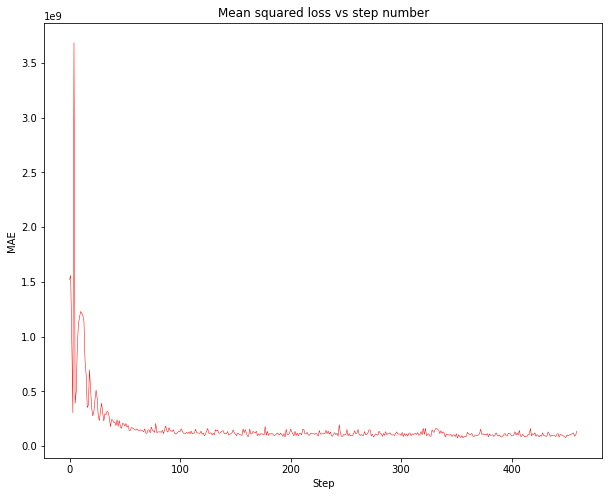

In [151]:
# x = np.linspace(0, np.size(cur_loss))
plt.figure(figsize=[10, 8])
plt.title("Mean squared loss vs step number")
plt.plot(cur_loss, 'red', linewidth=0.5)
plt.xlabel("Step")
plt.ylabel("MAE");

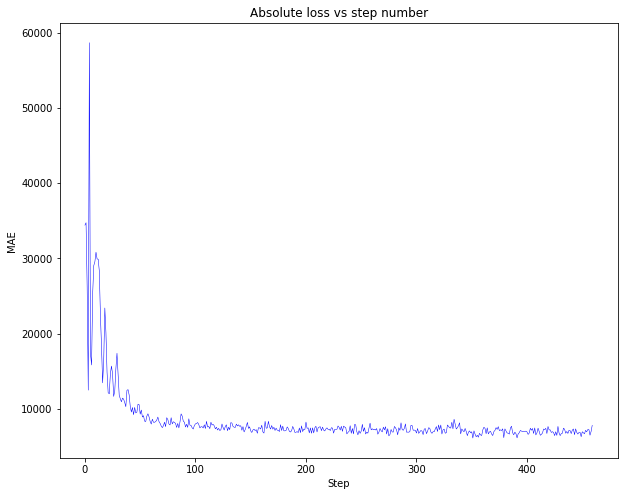

In [152]:
plt.figure(figsize=[10, 8])
plt.title("Absolute loss vs step number")
plt.plot(cur_abs, 'blue', linewidth=0.5)
plt.xlabel("Step")
plt.ylabel("MAE");

In [ ]:
# !tensorboard --logdir=summaries_dir/train/

In [153]:
MSE, AE = validate()
assert AE < 20000
print ("I earned 3 pts with %s absolute error!" % AE)

I earned 3 pts with 7001.95556641 absolute error!


# Done
     + **(1 pt)** Add visualisation of train and val loss. Try to use some smoothing to make plots more readable 
     + **(2 pt)** Try different CNN architectures. Vary kernel size, number of filters. Find out if there is some change to a training process.
     + Try to use different architectures for different inputs. Maybe a smaller architecture would be fine for description field and more complex for a title.
     + Find out the best **embedding size** value 
     + Add dropout, 
     - and some regularisation 
 
 **(2++ pts) for all experimenting**

So, according to experiments, there were established some values of variables that I cant explain easily.

Firstly, I forked input and did convolutions and poolings, then merged and dropouted 50 percent. Works nice. 

Secondly, I tried to use some different stuff such average for short texts as title, but it was not any better in terms of stability of learning. 

Thirdly, I changed batch size, because it took ages to calculate anything. If I had stronge gpu so I cant did 500. Yet its only 300

Fourthly, as for embedding size, It was found out empirically that the best one is 128

# See in the next series
 - Recurrent neural networks
  - Why everybody like them
  - Why everybody hate them
 - Attention for text processing
  - How to boost your NLP model performance by implementing recent DL paper